<a href="https://colab.research.google.com/github/ericyoc/cnn_hnn_comparison_analysis/blob/main/cnn_hnn_adv_attacks_comparsion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install torchattacks

In [2]:
#pip install cirq

In [3]:
#!pip install tabulate

In [4]:
from tabulate import tabulate

In [5]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Access the mounted drive
drive_path = '/content/drive/My Drive/'

data_dir = drive_path + 'data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Epoch 1/10
Train Loss: 0.3639, Train Accuracy: 0.8935
Epoch 2/10
Train Loss: 0.0998, Train Accuracy: 0.9699
Epoch 3/10
Train Loss: 0.0713, Train Accuracy: 0.9784
Epoch 4/10
Train Loss: 0.0615, Train Accuracy: 0.9821
Epoch 5/10
Train Loss: 0.0508, Train Accuracy: 0.9844
Epoch 6/10
Train Loss: 0.0422, Train Accuracy: 0.9865
Epoch 7/10
Train Loss: 0.0378, Train Accuracy: 0.9878
Epoch 8/10
Train Loss: 0.0332, Train Accuracy: 0.9895
Epoch 9/10
Train Loss: 0.0288, Train Accuracy: 0.9905
Epoch 10/10
Train Loss: 0.0253, Train Accuracy: 0.9919
Epoch 1/10
Train Loss: 0.0281, Train Accuracy: 0.9910
Epoch 2/10
Train Loss: 0.0234, Train Accuracy: 0.9924
Epoch 3/10
Train Loss: 0.0187, Train Accuracy: 0.9941
Epoch 4/10
Train Loss: 0.0175, Train Accuracy: 0.9948
Epoch 5/10
Train Loss: 0.0162, Train Accuracy: 0.9948
Epoch 6/10
Train Loss: 0.0148, Train Accuracy: 0.9954
Epoch 7/10
Train Loss: 0.0137, Train Accuracy: 0.9952
Epoch 8/10
Train Loss: 0.0114, Train Accuracy: 0.9962
Epoch 9/10
Train Loss: 0.01

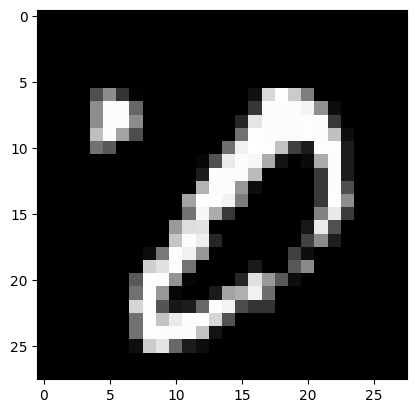

Original label: 0, CNN prediction: 9, HNN prediction: 9


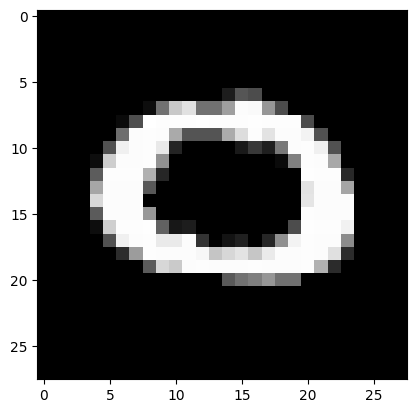

Original label: 0, CNN prediction: 6, HNN prediction: 6


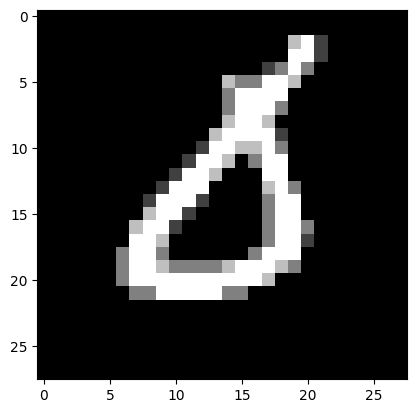

Original label: 0, CNN prediction: 1, HNN prediction: 1


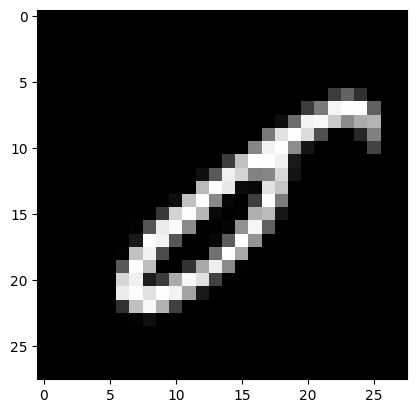

Original label: 0, CNN prediction: 2, HNN prediction: 2


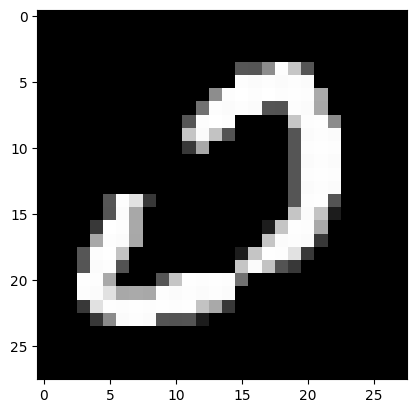

Original label: 0, CNN prediction: 7, HNN prediction: 7


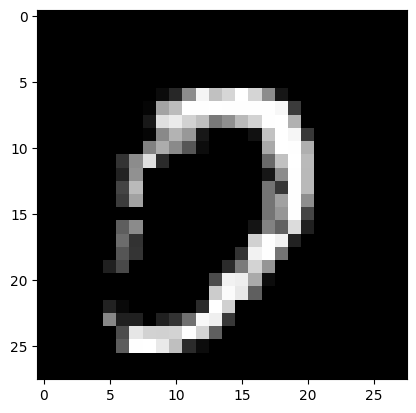

Attack       Pre-Attack CNN Acc (%)    Pre-Attack CNN Loss    Post-Attack CNN Acc (%)    Post-Attack CNN Loss    Pre-Attack HNN Acc (%)    Pre-Attack HNN Loss    Post-Attack HNN Acc (%)    Post-Attack HNN Loss
---------  ------------------------  ---------------------  -------------------------  ----------------------  ------------------------  ---------------------  -------------------------  ----------------------
GN + FGSM                     99.03                   0.07                      87.50                    0.82                     99.03                   0.04                      87.50                    0.28
Attack      Pre-Attack CNN Acc (%)    Pre-Attack CNN Loss    Post-Attack CNN Acc (%)    Post-Attack CNN Loss    Pre-Attack HNN Acc (%)    Pre-Attack HNN Loss    Post-Attack HNN Acc (%)    Post-Attack HNN Loss
--------  ------------------------  ---------------------  -------------------------  ----------------------  ------------------------  ---------------------  --

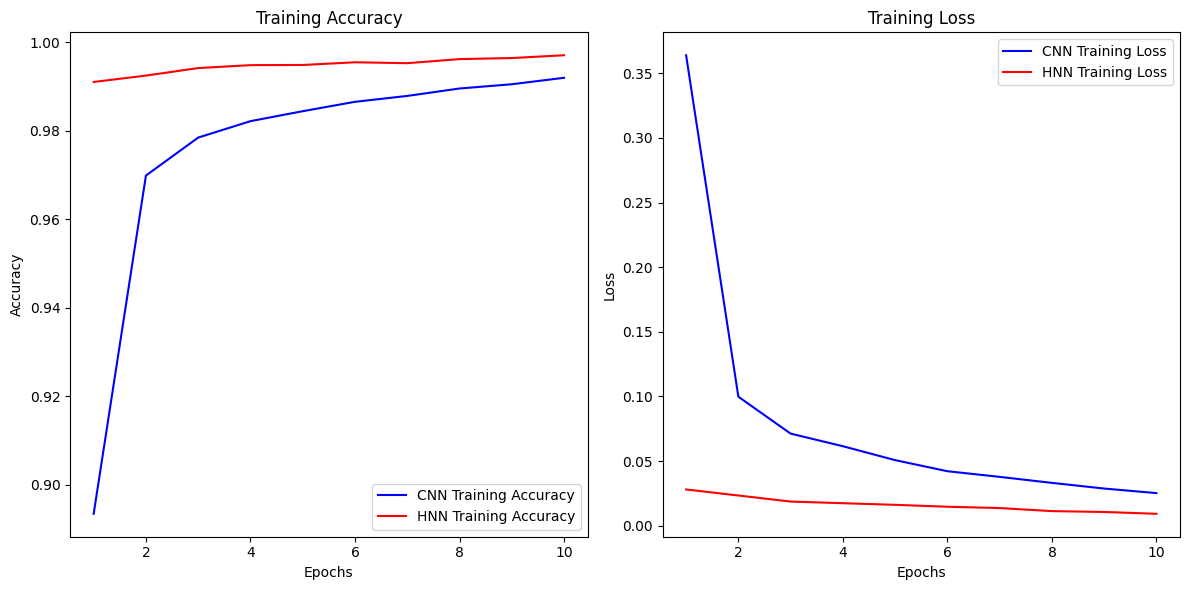

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import math
import cirq
import os
import matplotlib.pyplot as plt
import torchattacks
from itertools import permutations
import copy
from tabulate import tabulate

# Define the CNN model
class CNN(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, 5)
        self.conv2 = nn.Conv2d(4, 10, 5)
        self.fc1 = nn.Linear(160, 80)
        self.fc2 = nn.Linear(80, 10)
        self.device = device
        self.to(device)
        self._training = True

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 160)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    @property
    def shape(self):
        return (1, 28, 28)

    def clone(self):
        return copy.deepcopy(self)

    @property
    def num_classes(self):
        return 10

    @property
    def training(self):
        return self._training

    @training.setter
    def training(self, mode):
        self._training = mode

    def detach(self):
        for param in self.parameters():
            param.detach_()
        return self

# Create the quantum circuit
def create_quantum_circuit(theta, phi, output_dim):
    num_qubits = int(math.ceil(math.log2(output_dim)))
    qubits = cirq.LineQubit.range(num_qubits)
    circuit = cirq.Circuit()
    for i, qubit in enumerate(qubits):
        if i % 2 == 0:
            circuit.append(cirq.ry(float(theta))(qubit))
        else:
            circuit.append(cirq.ry(float(phi))(qubit))
    for i in range(num_qubits - 1):
        circuit.append(cirq.CNOT(qubits[i], qubits[i+1]))
    return circuit

# Simulate the quantum circuit
def simulate_circuit(circuit, device):
    simulator = cirq.Simulator()
    result = simulator.simulate(circuit)
    final_state_vector = result.final_state_vector
    return final_state_vector

# Define the hybrid forward pass
def hybrid_forward(input_data, classical_model, theta, phi, device, output_dim=10):
    input_data = input_data.to(device)
    classical_output = classical_model(input_data)
    quantum_circuit = create_quantum_circuit(theta, phi, output_dim)
    simulator = cirq.Simulator()
    result = simulator.simulate(quantum_circuit)
    quantum_output_amplitudes = result.final_state_vector
    batch_size = classical_output.size(0)
    classical_output = classical_output.view(batch_size, -1)
    num_qubits = int(math.ceil(math.log2(output_dim)))
    expected_quantum_output_size = 2 ** num_qubits
    quantum_output_probabilities = np.square(np.abs(quantum_output_amplitudes))
    quantum_output_probabilities = quantum_output_probabilities.reshape(expected_quantum_output_size)[:output_dim]
    quantum_output_probabilities = np.tile(quantum_output_probabilities, (batch_size, 1))
    quantum_output_probabilities = torch.from_numpy(quantum_output_probabilities).to(device)
    alpha = 0.5
    beta = 0.5
    hybrid_output = alpha * classical_output + beta * quantum_output_probabilities
    hybrid_output = F.log_softmax(hybrid_output, dim=1)
    return hybrid_output

# Define the HNN model
class HNN(nn.Module):
    def __init__(self, classical_model, device, output_dim=10):
        super(HNN, self).__init__()
        self.classical_model = classical_model
        self.output_dim = output_dim
        self.theta = nn.Parameter(torch.randn(1))
        self.phi = nn.Parameter(torch.randn(1))
        self.device = device
        if device is not None:
            self.to(device)

    def forward(self, input_data):
        return hybrid_forward(input_data, self.classical_model, self.theta, self.phi, self.device, self.output_dim)

# Load the dataset
data_dir = 'data'  # Update with the correct data directory path
train_set = datasets.MNIST(data_dir, train=True, download=True, transform=transforms.ToTensor())
test_set = datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor())

# Filter the dataset
def filtered_dataset(train_set, test_set, filtered=0):
    if filtered == 0:  # digits 0 and 1
        train_indexes_0 = torch.where(train_set.targets == 0)[0]
        train_indexes_1 = torch.where(train_set.targets == 1)[0]
        test_indexes_0 = torch.where(test_set.targets == 0)[0]
        test_indexes_1 = torch.where(test_set.targets == 1)[0]

        num_to_sample_train = min(len(train_indexes_0), len(train_indexes_1))
        num_to_sample_test = min(len(test_indexes_0), len(test_indexes_1))

        sampled_train_indexes_0 = train_indexes_0[torch.randperm(len(train_indexes_0))[:num_to_sample_train]]
        sampled_train_indexes_1 = train_indexes_1[torch.randperm(len(train_indexes_1))[:num_to_sample_train]]
        sampled_test_indexes_0 = test_indexes_0[torch.randperm(len(test_indexes_0))[:num_to_sample_test]]
        sampled_test_indexes_1 = test_indexes_1[torch.randperm(len(test_indexes_1))[:num_to_sample_test]]

        selected_train_indexes = torch.cat([sampled_train_indexes_0, sampled_train_indexes_1])
        selected_test_indexes = torch.cat([sampled_test_indexes_0, sampled_test_indexes_1])

    elif filtered == 1:  # digits 0 to 9
        train_indexes = []
        test_indexes = []
        for i in range(10):
            train_idx = torch.where(train_set.targets == i)[0]
            test_idx = torch.where(test_set.targets == i)[0]

            train_indexes.append(train_idx)
            test_indexes.append(test_idx)

        min_num_samples_train = min(len(idx) for idx in train_indexes)
        min_num_samples_test = min(len(idx) for idx in test_indexes)

        sampled_train_indexes = []
        sampled_test_indexes = []
        for train_idx, test_idx in zip(train_indexes, test_indexes):
            sampled_train_indexes.append(train_idx[torch.randperm(len(train_idx))[:min_num_samples_train]])
            sampled_test_indexes.append(test_idx[torch.randperm(len(test_idx))[:min_num_samples_test]])

        selected_train_indexes = torch.cat(sampled_train_indexes)
        selected_test_indexes = torch.cat(sampled_test_indexes)

    else:
        raise ValueError("Invalid value for 'filtered'. Choose either 0 or 1.")

    filtered_train_set = torch.utils.data.Subset(train_set, selected_train_indexes)
    filtered_test_set = torch.utils.data.Subset(test_set, selected_test_indexes)

    return filtered_train_set, filtered_test_set

filtered_train_set, filtered_test_set = filtered_dataset(train_set, test_set, filtered=1)

# Create data loaders
filtered_train_loader = DataLoader(filtered_train_set, batch_size=64, shuffle=True)
filtered_test_loader = DataLoader(filtered_test_set, batch_size=64)

# Set up the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Create instances of the CNN and HNN models
classical_model = CNN(device).to(device)
hybrid_model = HNN(classical_model, device=device, output_dim=10).to(device)

# Set up the optimizers and loss function
cnn_optimizer = optim.Adam(classical_model.parameters())
hnn_optimizer = optim.Adam(hybrid_model.parameters())
loss_fn = nn.NLLLoss()

# Train the CNN
def train_cnn(model, train_loader, loss_fn, optimizer, num_epochs, device):
    train_accuracies = []
    train_losses = []
    model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for i, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(preds.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)

    return train_accuracies, train_losses

# Train the HNN
def train_hnn(model, train_loader, loss_fn, optimizer, num_epochs, device):
    train_accuracies = []
    train_losses = []
    model.to(device)

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for i, (imgs, labels) in enumerate(train_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(preds.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = train_correct / train_total
        print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
        train_accuracies.append(train_acc)
        train_losses.append(train_loss)

    return train_accuracies, train_losses

# Evaluate the models
def evaluate(model, data_loader, loss_fn, device):
    test_loss = 0.0
    test_accuracy = 0.0
    model.eval()

    with torch.no_grad():
        for i, (x, y) in enumerate(data_loader):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            batch_loss = loss_fn(logits, y)
            test_loss += batch_loss.item()
            preds = torch.argmax(logits, dim=1)
            test_accuracy += torch.sum(preds == y).item() / len(y)

    test_loss /= len(data_loader)
    test_accuracy /= len(data_loader)
    return test_loss, test_accuracy

def perform_attack(model, data, labels, attack):
    adv_data = attack(data, labels)
    return adv_data

def print_attack_results(model, test_loader, loss_fn, device, attack_list):
    headers = ['Attack', 'Pre-Attack CNN Acc (%)', 'Pre-Attack CNN Loss', 'Post-Attack CNN Acc (%)', 'Post-Attack CNN Loss', 'Pre-Attack HNN Acc (%)', 'Pre-Attack HNN Loss', 'Post-Attack HNN Acc (%)', 'Post-Attack HNN Loss']
    table = []

    # Get pre-attack accuracy and loss
    cnn_test_loss, cnn_test_accuracy = evaluate(classical_model, filtered_test_loader, loss_fn, device)
    hnn_test_loss, hnn_test_accuracy = evaluate(hybrid_model, filtered_test_loader, loss_fn, device)

    for attack in attack_list:
        attack_name = type(attack).__name__
        attack_components = attack_name.split('+')
        attack_description = ' + '.join(attack_components)

        # Evaluate pre-attack performance
        cnn_pre_attack_acc = f"{cnn_test_accuracy * 100:.2f}"
        cnn_pre_attack_loss = f"{cnn_test_loss:.2f}"
        hnn_pre_attack_acc = f"{hnn_test_accuracy * 100:.2f}"
        hnn_pre_attack_loss = f"{hnn_test_loss:.2f}"

        # Perform attack
        for data, labels in filtered_test_loader:
            data, labels = data.to(device), labels.to(device)
            cnn_adv_data = perform_attack(classical_model, data, labels, attack)
            hnn_adv_data = perform_attack(hybrid_model, data, labels, attack)

            # Evaluate post-attack performance
            cnn_post_attack_loss, cnn_post_attack_acc = evaluate(classical_model, [(cnn_adv_data, labels)], loss_fn, device)
            hnn_post_attack_loss, hnn_post_attack_acc = evaluate(hybrid_model, [(hnn_adv_data, labels)], loss_fn, device)

        row = [attack_description, cnn_pre_attack_acc, cnn_pre_attack_loss, f"{cnn_post_attack_acc * 100:.2f}", f"{cnn_post_attack_loss:.2f}", hnn_pre_attack_acc, hnn_pre_attack_loss, f"{hnn_post_attack_acc * 100:.2f}", f"{hnn_post_attack_loss:.2f}"]
        table.append(row)

    print(tabulate(table, headers=headers, floatfmt=".2f"))


def main():
    # Train the models
    num_epochs = 10
    cnn_train_accuracies, cnn_train_losses = train_cnn(classical_model, filtered_train_loader, loss_fn, cnn_optimizer, num_epochs, device)
    hnn_train_accuracies, hnn_train_losses = train_hnn(hybrid_model, filtered_train_loader, loss_fn, hnn_optimizer, num_epochs, device)

    # Evaluate the models
    cnn_test_loss, cnn_test_accuracy = evaluate(classical_model, filtered_test_loader, loss_fn, device)
    hnn_test_loss, hnn_test_accuracy = evaluate(hybrid_model, filtered_test_loader, loss_fn, device)

    print(f"CNN Test Loss: {cnn_test_loss:.4f}, CNN Test Accuracy: {cnn_test_accuracy:.4f}")
    print(f"HNN Test Loss: {hnn_test_loss:.4f}, HNN Test Accuracy: {hnn_test_accuracy:.4f}")

    # Print a sample of images with different original and predicted labels
    sample_size = 6
    misclassified_images = []
    with torch.no_grad():
        for i, (x, y) in enumerate(filtered_test_loader):
            x, y = x.to(device), y.to(device)
            cnn_preds = classical_model(x)
            hnn_preds = hybrid_model(x)
            cnn_preds = torch.argmax(cnn_preds, dim=1)
            hnn_preds = torch.argmax(hnn_preds, dim=1)
            misclassified_cnn = (cnn_preds != y)
            misclassified_hnn = (hnn_preds != y)
            misclassified_images.extend([(x[i], y[i], cnn_preds[i], hnn_preds[i]) for i in range(len(x)) if misclassified_cnn[i] or misclassified_hnn[i]])
            if len(misclassified_images) >= sample_size:
                break

    if misclassified_images:
        print("Sample of misclassified images:")
        for img, label, cnn_pred, hnn_pred in misclassified_images[:sample_size]:
            print(f"Original label: {label}, CNN prediction: {cnn_pred}, HNN prediction: {hnn_pred}")
            if len(img.shape) == 3:
                plt.imshow(img.cpu().permute(1, 2, 0), cmap='gray')
            else:
                plt.imshow(img.cpu().squeeze(), cmap='gray')
            plt.show()
    else:
        print("No misclassified images found.")

    # Create the list of individual attacks
    attacks = [
        "GN",
        "FGSM",
        "BIM",
        "CW",
        "RFGSM",
        "PGD (Linf)",
        "PGD (L2)",
        "MIFGSM",
        "TPGD",
        "EOTPGD",
        "APGD",
        "DIFGSM (Linf)",
        "Jitter (Linf)"
    ]

    headers = ['Attack', 'Pre-Attack CNN Acc (%)', 'Pre-Attack CNN Loss', 'Post-Attack CNN Acc (%)', 'Post-Attack CNN Loss', 'Pre-Attack HNN Acc (%)', 'Pre-Attack HNN Loss', 'Post-Attack HNN Acc (%)', 'Post-Attack HNN Loss']
    table = []

    # Get pre-attack accuracy and loss
    cnn_test_loss, cnn_test_accuracy = evaluate(classical_model, filtered_test_loader, loss_fn, device)
    hnn_test_loss, hnn_test_accuracy = evaluate(hybrid_model, filtered_test_loader, loss_fn, device)

    compound_attacks = []
    for attack1_name, attack2_name in permutations(attacks, 2):
        try:

            if attack1_name == "GN":
                cnn_attack1 = torchattacks.GN(classical_model, std=0.1)
                hnn_attack1 = torchattacks.GN(hybrid_model, std=0.1)
            elif attack1_name == "FGSM":
                cnn_attack1 = torchattacks.FGSM(classical_model, eps=8/255)
                hnn_attack1 = torchattacks.FGSM(hybrid_model, eps=8/255)
            elif attack1_name == "BIM":
                cnn_attack1 = torchattacks.BIM(classical_model, eps=8/255, alpha=2/255, steps=10)
                hnn_attack1 = torchattacks.BIM(hybrid_model, eps=8/255, alpha=2/255, steps=10)
            elif attack1_name == "RFGSM":
                cnn_attack1 = torchattacks.BIM(classical_model, eps=8/255, alpha=2/255, steps=10)
                hnn_attack1 = torchattacks.BIM(hybrid_model, eps=8/255, alpha=2/255, steps=10)
            elif attack1_name == "PGD (Linf)":
                cnn_attack1 = torchattacks.PGD(classical_model, eps=8/255, alpha=1/255, steps=10, random_start=True)
                hnn_attack1 = torchattacks.PGD(hybrid_model, eps=8/255, alpha=1/255, steps=10, random_start=True)
            elif attack1_name == "PGD (L2)":
                cnn_attack1 = torchattacks.PGDL2(classical_model, eps=1.0, alpha=0.2, steps=10, random_start=True)
                hnn_attack1 = torchattacks.PGDL2(hybrid_model, eps=1.0, alpha=0.2, steps=10, random_start=True)
            elif attack1_name == "MIFGSM":
                cnn_attack1 = torchattacks.MIFGSM(classical_model, eps=8/255, steps=10, decay=1.0)
                hnn_attack1 = torchattacks.MIFGSM(hybrid_model, eps=8/255, steps=10, decay=1.0)
            elif attack1_name == "TPGD":
                cnn_attack1 = torchattacks.TPGD(classical_model, eps=8/255, alpha=2/255, steps=10)
                hnn_attack1 = torchattacks.TPGD(hybrid_model, eps=8/255, alpha=2/255, steps=10)
            elif attack1_name == "EOTPGD":
                cnn_attack1 = torchattacks.EOTPGD(classical_model, eps=8/255, alpha=2/255, steps=10, eot_iter=2)
                hnn_attack1 = torchattacks.EOTPGD(hybrid_model, eps=8/255, alpha=2/255, steps=10, eot_iter=2)
            elif attack1_name == "APGD":
                cnn_attack1 = torchattacks.APGD(classical_model, norm='Linf', eps=8/255, steps=10, n_restarts=1, seed=0, loss='ce', eot_iter=1, rho=.75, verbose=False)
                hnn_attack1 = torchattacks.APGD(hybrid_model, norm='Linf', eps=8/255, steps=10, n_restarts=1, seed=0, loss='ce', eot_iter=1, rho=.75, verbose=False)
            elif attack1_name == "DIFGSM (Linf)":
                cnn_attack1 = torchattacks.DIFGSM(classical_model, eps=8/255, alpha=2/255, steps=10, decay=0.0, resize_rate=0.9, diversity_prob=0.5, random_start=False)
                hnn_attack1 = torchattacks.DIFGSM(hybrid_model, eps=8/255, alpha=2/255, steps=10, decay=0.0, resize_rate=0.9, diversity_prob=0.5, random_start=False)
            elif attack1_name == "Jitter (Linf)":
                cnn_attack1 = torchattacks.Jitter(classical_model, eps=8/255, alpha=2/255, steps=10, scale=10, std=0.1, random_start=True)
                hnn_attack1 = torchattacks.Jitter(hybrid_model, eps=8/255, alpha=2/255, steps=10, scale=10, std=0.1, random_start=True)
            elif attack1_name == "CW":
                cnn_attack1 = torchattacks.CW(classical_model, c=1, kappa=0, steps=200, lr=0.01)
                hnn_attack1 = torchattacks.CW(hybrid_model, c=1, kappa=0, steps=200, lr=0.01)
            else:
                raise ValueError(f"Unsupported attack type: {attack1_name}")

            if attack2_name == "GN":
                cnn_attack2 = torchattacks.GN(classical_model, std=0.1)
                hnn_attack2 = torchattacks.GN(hybrid_model, std=0.1)
            elif attack2_name == "FGSM":
                cnn_attack2 = torchattacks.FGSM(classical_model, eps=8/255)
                hnn_attack2 = torchattacks.FGSM(hybrid_model, eps=8/255)
            elif attack2_name == "BIM":
                cnn_attack2 = torchattacks.BIM(classical_model, eps=8/255, alpha=2/255, steps=10)
                hnn_attack2 = torchattacks.BIM(hybrid_model, eps=8/255, alpha=2/255, steps=10)
            elif attack2_name == "RFGSM":
                cnn_attack2 = torchattacks.BIM(classical_model, eps=8/255, alpha=2/255, steps=10)
                hnn_attack2 = torchattacks.BIM(hybrid_model, eps=8/255, alpha=2/255, steps=10)
            elif attack2_name == "PGD (Linf)":
                cnn_attack2 = torchattacks.PGD(classical_model, eps=8/255, alpha=1/255, steps=10, random_start=True)
                hnn_attack2 = torchattacks.PGD(hybrid_model, eps=8/255, alpha=1/255, steps=10, random_start=True)
            elif attack2_name == "PGD (L2)":
                cnn_attack2 = torchattacks.PGDL2(classical_model, eps=1.0, alpha=0.2, steps=10, random_start=True)
                hnn_attack2 = torchattacks.PGDL2(hybrid_model, eps=1.0, alpha=0.2, steps=10, random_start=True)
            elif attack2_name == "MIFGSM":
                cnn_attack2 = torchattacks.MIFGSM(classical_model, eps=8/255, steps=10, decay=1.0)
                hnn_attack2 = torchattacks.MIFGSM(hybrid_model, eps=8/255, steps=10, decay=1.0)
            elif attack2_name == "TPGD":
                cnn_attack2 = torchattacks.TPGD(classical_model, eps=8/255, alpha=2/255, steps=10)
                hnn_attack2 = torchattacks.TPGD(hybrid_model, eps=8/255, alpha=2/255, steps=10)
            elif attack2_name == "EOTPGD":
                cnn_attack2 = torchattacks.EOTPGD(classical_model, eps=8/255, alpha=2/255, steps=10, eot_iter=2)
                hnn_attack2 = torchattacks.EOTPGD(hybrid_model, eps=8/255, alpha=2/255, steps=10, eot_iter=2)
            elif attack2_name == "APGD":
                cnn_attack2 = torchattacks.APGD(classical_model, norm='Linf', eps=8/255, steps=10, n_restarts=1, seed=0, loss='ce', eot_iter=1, rho=.75, verbose=False)
                hnn_attack2 = torchattacks.APGD(hybrid_model, norm='Linf', eps=8/255, steps=10, n_restarts=1, seed=0, loss='ce', eot_iter=1, rho=.75, verbose=False)
            elif attack2_name == "DIFGSM (Linf)":
                cnn_attack2 = torchattacks.DIFGSM(classical_model, eps=8/255, alpha=2/255, steps=10, decay=0.0, resize_rate=0.9, diversity_prob=0.5, random_start=False)
                hnn_attack2 = torchattacks.DIFGSM(hybrid_model, eps=8/255, alpha=2/255, steps=10, decay=0.0, resize_rate=0.9, diversity_prob=0.5, random_start=False)
            elif attack2_name == "Jitter (Linf)":
                cnn_attack2 = torchattacks.Jitter(classical_model, eps=8/255, alpha=2/255, steps=10, scale=10, std=0.1, random_start=True)
                hnn_attack2 = torchattacks.Jitter(hybrid_model, eps=8/255, alpha=2/255, steps=10, scale=10, std=0.1, random_start=True)
            elif attack2_name == "CW":
                cnn_attack2 = torchattacks.CW(classical_model, c=1, kappa=0, steps=200, lr=0.01)
                hnn_attack2 = torchattacks.CW(hybrid_model, c=1, kappa=0, steps=200, lr=0.01)
            else:
                raise ValueError(f"Unsupported attack type: {attack2_name}")

            cnn_compound_attack = torchattacks.MultiAttack([cnn_attack1, cnn_attack2])
            hnn_compound_attack = torchattacks.MultiAttack([hnn_attack1, hnn_attack2])
            attack_description = f"{attack1_name} + {attack2_name}"

            # Evaluate pre-attack performance
            cnn_pre_attack_acc = f"{cnn_test_accuracy * 100:.2f}"
            cnn_pre_attack_loss = f"{cnn_test_loss:.2f}"
            hnn_pre_attack_acc = f"{hnn_test_accuracy * 100:.2f}"
            hnn_pre_attack_loss = f"{hnn_test_loss:.2f}"

            # Perform attack
            for data, labels in filtered_test_loader:
                data, labels = data.to(device), labels.to(device)
                cnn_adv_data = perform_attack(classical_model, data, labels, cnn_compound_attack)
                hnn_adv_data = perform_attack(hybrid_model, data, labels, hnn_compound_attack)

                # Evaluate post-attack performance
                cnn_post_attack_loss, cnn_post_attack_acc = evaluate(classical_model, [(cnn_adv_data, labels)], loss_fn, device)
                hnn_post_attack_loss, hnn_post_attack_acc = evaluate(hybrid_model, [(hnn_adv_data, labels)], loss_fn, device)

            row = [attack_description, cnn_pre_attack_acc, cnn_pre_attack_loss, f"{cnn_post_attack_acc * 100:.2f}", f"{cnn_post_attack_loss:.2f}", hnn_pre_attack_acc, hnn_pre_attack_loss, f"{hnn_post_attack_acc * 100:.2f}", f"{hnn_post_attack_loss:.2f}"]
            table.append(row)

            print(tabulate([row], headers=headers, floatfmt=".2f"))

        except (AttributeError, ValueError) as e:
            print(f"Error: {e}")

    print("\nFinal Results:")
    print(tabulate(table, headers=headers, floatfmt=".2f"))


    #Find the top three compound attacks with the greatest accuracy difference for CNN and HNN
    cnn_accuracy_diffs = [(row[0], float(row[1]) - float(row[3])) for row in table]
    hnn_accuracy_diffs = [(row[0], float(row[5]) - float(row[7])) for row in table]

    cnn_top_attacks = sorted(cnn_accuracy_diffs, key=lambda x: x[1], reverse=True)[:3]
    hnn_top_attacks = sorted(hnn_accuracy_diffs, key=lambda x: x[1], reverse=True)[:3]

    cnn_top_table = []
    hnn_top_table = []

    for attack, diff in cnn_top_attacks:
        row = [attack, f"{diff:.2f}"]
        cnn_top_table.append(row)

    for attack, diff in hnn_top_attacks:
        row = [attack, f"{diff:.2f}"]
        hnn_top_table.append(row)

    print("\nTop 3 Compound Attacks with Greatest Accuracy Difference for CNN:")
    print(tabulate(cnn_top_table, headers=["Attack", "Accuracy Difference (%)"], floatfmt=".2f"))

    print("\nTop 3 Compound Attacks with Greatest Accuracy Difference for HNN:")
    print(tabulate(hnn_top_table, headers=["Attack", "Accuracy Difference (%)"], floatfmt=".2f"))

    # Plot the accuracy and loss curves
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, cnn_train_accuracies, 'b', label='CNN Training Accuracy')
    plt.plot(epochs, hnn_train_accuracies, 'r', label='HNN Training Accuracy')
    plt.title('Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, cnn_train_losses, 'b', label='CNN Training Loss')
    plt.plot(epochs, hnn_train_losses, 'r', label='HNN Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
